In [1]:
#from scipy import stats
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
#from scipy.optimize import curve_fit
#%matplotlib inline
# Suppress warnings. Comment this out if you wish to see the warning messages
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from tqdm import tqdm
import corner
import emcee

(86964, 20)


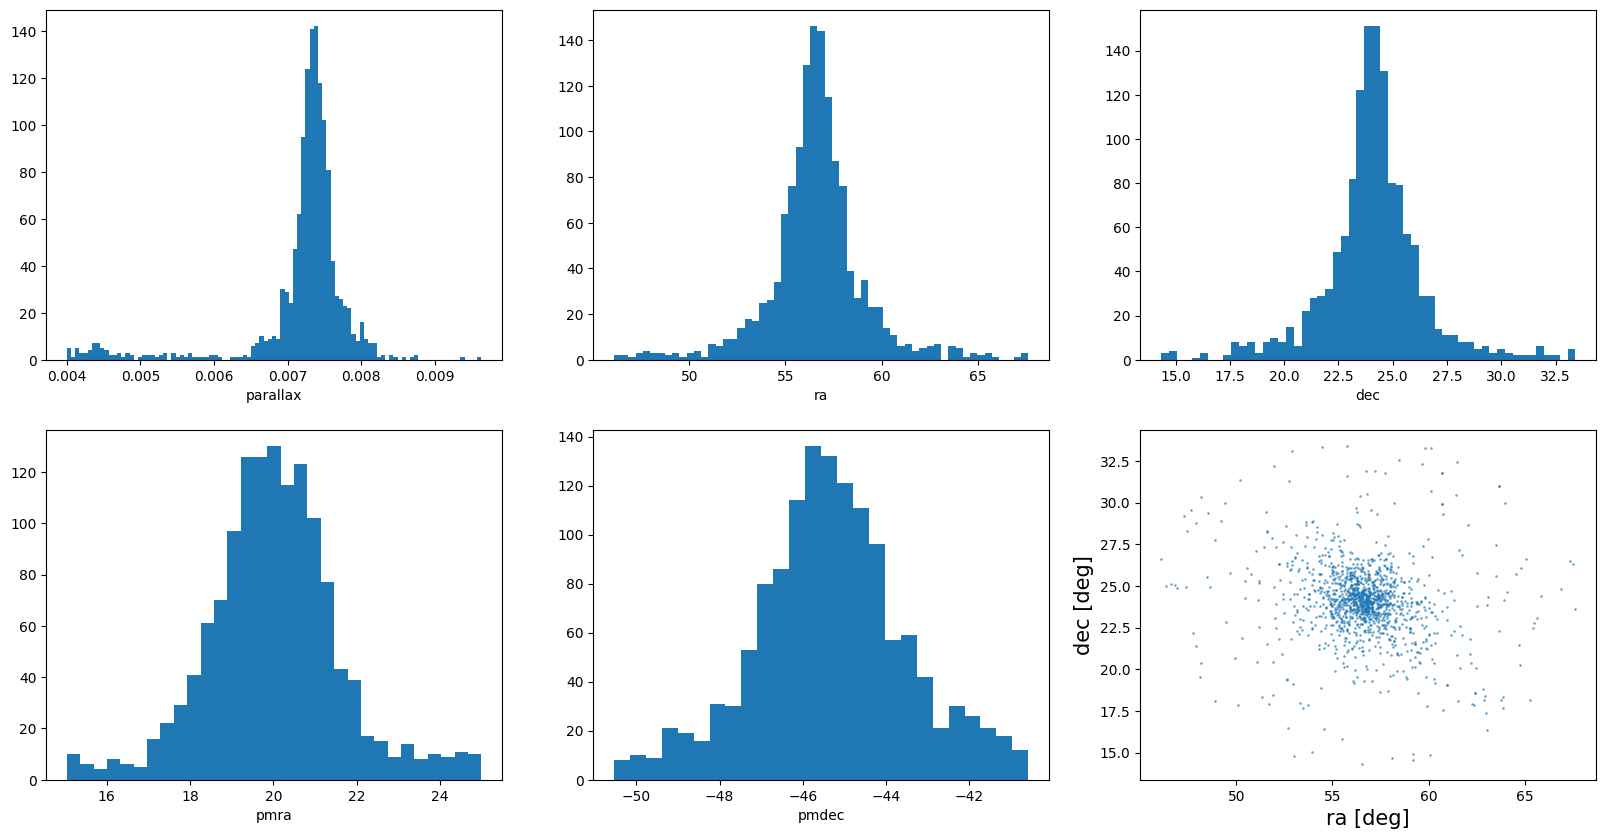

1359


In [2]:
df = pd.read_csv('./pleiades_10.csv')
#df.loc[df['ra'] > 300, 'ra'] -= 360 #SOLO PARA BLANCO 1
df = df.fillna(0)
df['parallax'] = df['parallax'] / 1000
df['parallax_error'] = df['parallax_error'] / 1000
print(df.shape)

mu_alpha, mu_delta = 19.997, -45.548
rango = 5
c_pm=(df['pmra'] > mu_alpha - rango) & (df['pmra'] < mu_alpha + rango) & \
                        (df['pmdec'] > mu_delta - rango) & (df['pmdec'] < mu_delta + rango)
c_p = (df['parallax'] > 0.004) & (df['parallax'] < 0.01)

df = df[c_pm & c_p]

plt.figure(figsize=(20,10))

plt.subplot(2,3,1)
plt.hist(df.parallax,bins='auto')
plt.xlabel('parallax')

plt.subplot(2,3,2)
plt.hist(df.ra,bins='auto')
plt.xlabel('ra')

plt.subplot(2,3,3)
plt.hist(df.dec,bins='auto')
plt.xlabel('dec')

plt.subplot(2,3,4)
plt.hist(df.pmra,bins='auto')
#plt.xlim(-100,100)
plt.xlabel('pmra')

plt.subplot(2,3,5)
plt.hist(df.pmdec,bins='auto')
#plt.xlim(-100,100)
plt.xlabel('pmdec')

plt.subplot(2,3,6)
plt.scatter(df['ra'], df['dec'], marker='o' , s=1, alpha = 0.5)
plt.xlabel("ra [deg]",  fontsize = 15)
plt.ylabel("dec [deg]",  fontsize = 15)#,rotation=0)
#plt.xlim(-30,0)
#plt.ylim(0,30)
plt.show()

print(len(df))

In [3]:
def gaussian_function(x, params):
    nc, sc, sf, mu_c, mu_f = params
    Ac = -0.5*((x - mu_c)/sc)**2
    Be = -0.5*((x - mu_f)/sf)**2
    return nc/(np.sqrt(2*np.pi)*sc)*np.exp(Ac) + (1-nc)/(np.sqrt(2*np.pi)*sf)*np.exp(Be)

def log_likelihood(params, x):
    nc, sc, sf, mu_c, mu_f = params
    Ac = -0.5*((x - mu_c)/sc)**2
    Be = -0.5*((x - mu_f)/sf)**2
    y = nc/(np.sqrt(2*np.pi)*sc)*np.exp(Ac) + (1-nc)/(np.sqrt(2*np.pi)*sf)*np.exp(Be)
    # Calculate log likelihood
    return np.sum(np.log(y))

def log_prior(params):
    nc, sc, sf, mu_c, mu_f = params
    if 0.0 < nc < 1.0 and 0.0 < sc < 10.0 and 0.0 < sf < 10.0:
        return 0.0
    return -np.inf

def log_probability(params, x):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, x)

nll = lambda *args: -log_likelihood(*args)

In [4]:
sample_data = df.pmra
sc, sf = np.std(sample_data)/2, np.std(sample_data)
mu_c, mu_f = np.mean(sample_data), np.mean(sample_data)
initparams_pmra = [0.5, sc, sf, mu_c, mu_f]
print(log_likelihood(initparams_pmra, sample_data))
print(log_prior(initparams_pmra))
print(log_probability(initparams_pmra, sample_data))

results_pmra = minimize(nll, initparams_pmra, args=(sample_data), options={"disc":True}, method='Nelder-Mead')
results_pmra.x

-2574.8128046620714
0.0
-2574.8128046620714


array([ 0.61805723,  1.00640763,  2.23579727, 19.93378179, 20.14465459])

In [5]:
sample_data = df.pmdec
sc, sf = np.std(sample_data)/2, np.std(sample_data)
mu_c, mu_f = np.mean(sample_data), np.mean(sample_data)
initparams_pmdec = [0.5, sc, sf, mu_c, mu_f]
print(log_likelihood(initparams_pmdec, sample_data))
print(log_prior(initparams_pmdec))
print(log_probability(initparams_pmdec, sample_data))

results_pmdec = minimize(nll, initparams_pmdec, args=(sample_data), options={"disc":True}, method='Nelder-Mead')
results_pmdec.x

-2808.1427719609346
0.0
-2808.1427719609346


array([  0.24741074,   0.82975759,   2.06973124, -45.48281079,
       -45.27869664])

Text(0.5, 0, 'pmdec')

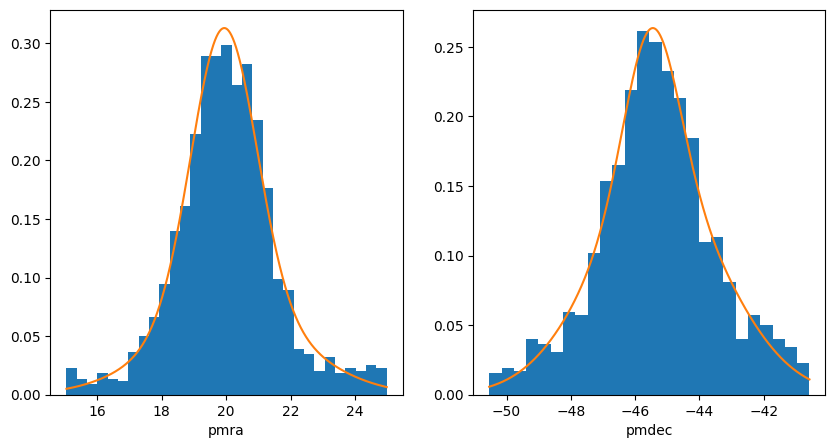

In [6]:
plt.figure(figsize=(10,5))
sample_data = df.pmra
plt.subplot(1,2,1)
bin_heights, bin_borders, _ = plt.hist(sample_data, bins='auto',
                                       range=(min(sample_data),max(sample_data)),density=True)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
x = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x, gaussian_function(x, results_pmra.x))
plt.xlabel('pmra')

plt.subplot(1,2,2)
sample_data = df.pmdec
bin_heights, bin_borders, _ = plt.hist(sample_data, bins='auto',
                                       range=(min(sample_data),max(sample_data)),density=True)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
x = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x, gaussian_function(x, results_pmdec.x))
plt.xlabel('pmdec')

In [7]:
sample_data = df.pmra
n_walkers, n_dim = 250, 5
p0 = results_pmra.x + 1e-4 * np.random.randn(n_walkers, n_dim)

sampler_pmra = emcee.EnsembleSampler(n_walkers, n_dim, log_probability, args=[sample_data])
pos, prob, state = sampler_pmra.run_mcmc(p0, 500, progress = True)

100%|█████████████████████████████████████████| 500/500 [02:01<00:00,  4.12it/s]


Text(0.5, 0, 'step number')

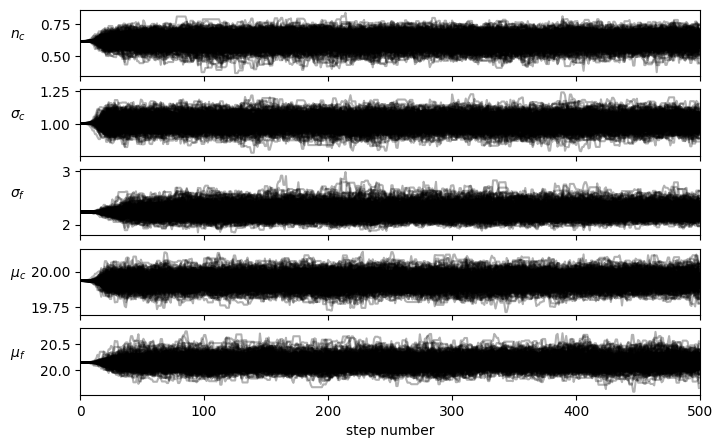

In [8]:
fig, axes = plt.subplots(n_dim, figsize=(8, 5), sharex=True)
samples = sampler_pmra.get_chain()
labels = ["$n_c$", "$\sigma_c$", "$\sigma_f$", "$\mu_c$", "$\mu_f$"]
for i in range(n_dim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

Minimize: [ 0.61805723  1.00640763  2.23579727 19.93378179 20.14465459]
MCMC:     [ 0.62157801  1.00889328  2.2391627  19.93440071 20.14756543]
(6500, 5)


<Figure size 800x800 with 0 Axes>

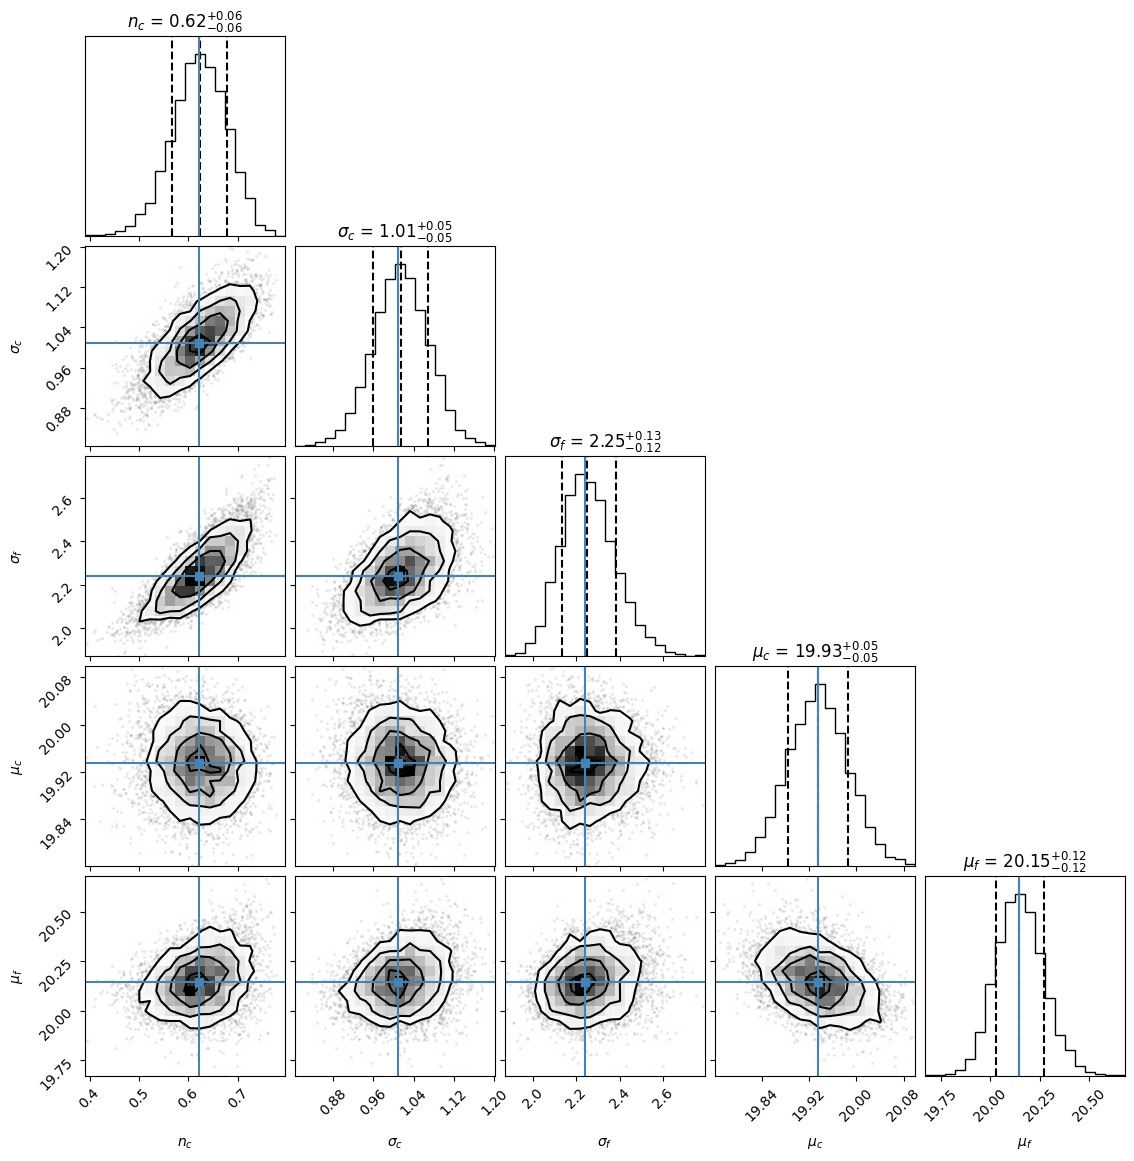

In [9]:
#tau = sampler.get_autocorr_time()
#print(tau)

params_mcmc_pmra = np.percentile(pos ,50, axis=0)
print('Minimize:',results_pmra.x)
print('MCMC:    ',params_mcmc_pmra)

flat_samples = sampler_pmra.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

truths = params_mcmc_pmra
plt.figure(figsize=(8,8))
fig = corner.corner(flat_samples, labels=labels, truths=truths, quantiles=[0.16, 0.5, 0.84], show_titles=True,
                      title_kwargs={"fontsize": 12})

In [10]:
sample_data = df.pmdec
n_walkers, n_dim = 250, 5
p0 = results_pmdec.x + 1e-4 * np.random.randn(n_walkers, n_dim)

sampler_pmdec = emcee.EnsembleSampler(n_walkers, n_dim, log_probability, args=[sample_data])
pos, prob, state = sampler_pmdec.run_mcmc(p0, 500, progress = True)

100%|█████████████████████████████████████████| 500/500 [02:02<00:00,  4.09it/s]


Text(0.5, 0, 'step number')

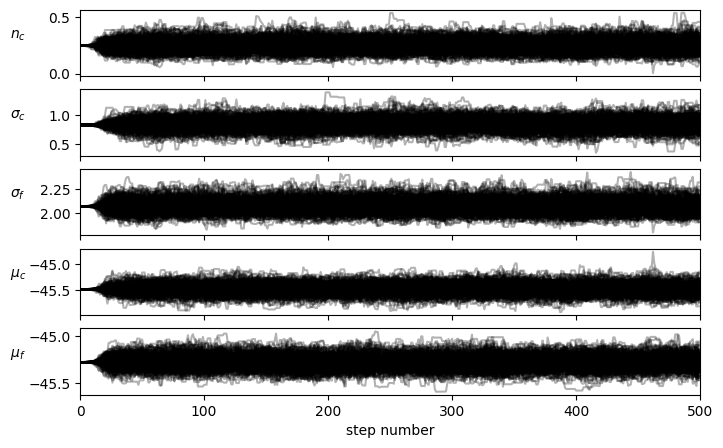

In [11]:
fig, axes = plt.subplots(n_dim, figsize=(8, 5), sharex=True)
samples = sampler_pmdec.get_chain()
labels = ["$n_c$", "$\sigma_c$", "$\sigma_f$", "$\mu_c$", "$\mu_f$"]
for i in range(n_dim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

Minimize: [  0.24741074   0.82975759   2.06973124 -45.48281079 -45.27869664]
MCMC:     [  0.2465201    0.85438268   2.06935924 -45.47849502 -45.28555288]
(6500, 5)


<Figure size 800x800 with 0 Axes>

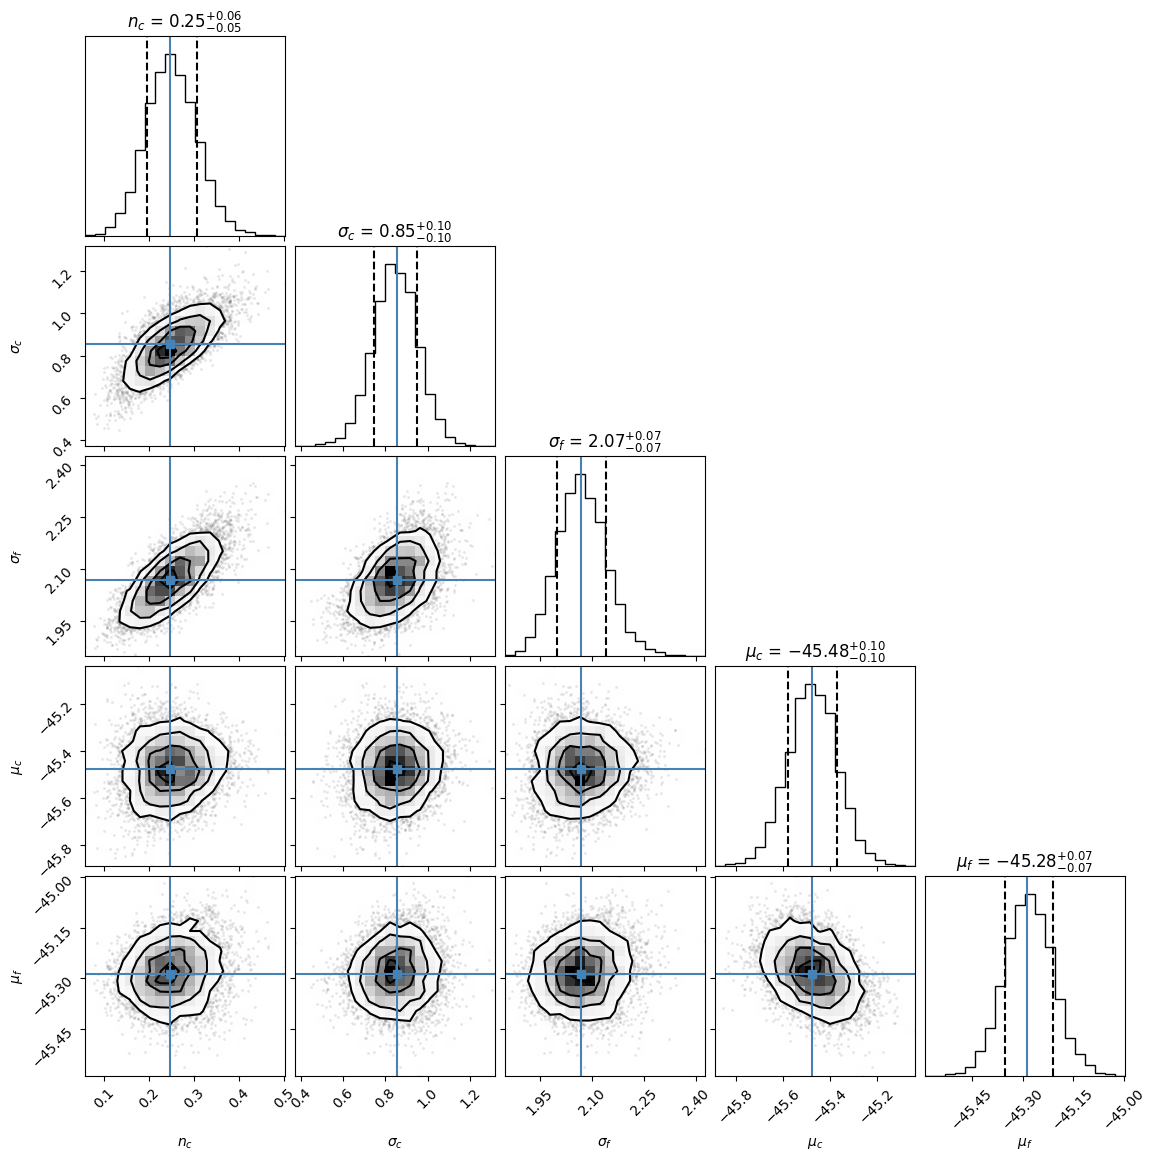

In [13]:
#tau = sampler.get_autocorr_time()
#print(tau)

params_mcmc_pmdec = np.percentile(pos ,50, axis=0)
print('Minimize:',results_pmdec.x)
print('MCMC:    ',params_mcmc_pmdec)

flat_samples = sampler_pmdec.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

truths = params_mcmc_pmdec
plt.figure(figsize=(8,8))
fig = corner.corner(flat_samples, labels=labels, truths=truths, quantiles=[0.16, 0.84], show_titles=True,
                      title_kwargs={"fontsize": 12})

Text(0.5, 0, 'pmdec')

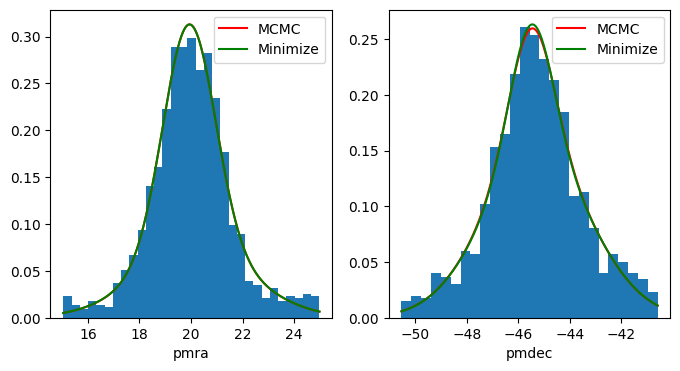

In [14]:
sample_data = df.pmra
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
bin_heights, bin_borders, _ = plt.hist(sample_data, bins='auto',
                                       range=(min(sample_data),max(sample_data)),density=True)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
x = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x, gaussian_function(x, params_mcmc_pmra), label='MCMC',color='red')
plt.plot(x, gaussian_function(x, results_pmra.x), label='Minimize', color='green')
plt.legend()
plt.xlabel('pmra')

plt.subplot(1,2,2)
sample_data = df.pmdec
bin_heights, bin_borders, _ = plt.hist(sample_data, bins='auto',
                                       range=(min(sample_data),max(sample_data)),density=True)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
x = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x, gaussian_function(x, params_mcmc_pmdec), label='MCMC',color='red')
plt.plot(x, gaussian_function(x, results_pmdec.x), label='Minimize',color='green')
plt.legend()
plt.xlabel('pmdec')

In [7]:
def log_prior(params):
    nc, s, sx, sy, rho, mu_xc, mu_yc, mu_xf, mu_yf = params
    if 0.0 < nc < 1.0 and 0.0 < s < 10.0 and 0.0 < sx < 10.0 and 0.0 < sy < 10.0 and -1.0 < rho < 1.0:
        return 0.0
    return -np.inf

def log_likelihood(params, x, y):
    nc, s, sx, sy, rho, mu_xc, mu_yc, mu_xf, mu_yf = params
    amp_circ = nc / (2 * np.pi * s**2)
    amp_elip = (1-nc) / (2 * np.pi * sx * sy * np.sqrt(1 - rho**2))
    Exp_circ = -0.5 * (((x - mu_xc)/s)**2 + ((y - mu_yc)/s)**2)
    Exp_elip = -1/(2*(1-rho**2))*(((x - mu_xf)/sx)**2+((y - mu_yf)/sy)**2-2*rho*((x - mu_xf)/sx)*((y - mu_yf)/sy))
    z = amp_circ * np.exp(Exp_circ) + amp_elip * np.exp(Exp_elip)
    # Calculate log likelihood
    return np.sum(np.log(z))

def log_probability(params, x, y):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, x, y)

In [8]:
x = df.pmra
y = df.pmdec
#nc, s, sx, sy, rho, mu_xc, mu_yc, mu_xf, mu_yf
rho_matrix = np.corrcoef(df.pmra, df.pmdec)
initparams = [0.5, results_pmra.x[1], results_pmra.x[2], results_pmdec.x[2], rho_matrix[0][1],
       results_pmra.x[3], results_pmdec.x[3], results_pmra.x[4], results_pmdec.x[4]]
print(initparams)
print(log_likelihood(initparams, x, y))
print(log_prior(initparams))
print(log_probability(initparams, x, y))

nll = lambda *args: -log_likelihood(*args)

results = minimize(nll, initparams, args=(x, y), options={"disc":True}, method='Nelder-Mead')
results.x

[0.5, 1.0064076342822925, 2.2357972683432257, 2.0697312351644546, -0.26937360451533576, 19.93378179337074, -45.48281079423144, 20.14465459498267, -45.27869663918549]
-5208.424957293915
0.0
-5208.424957293915


array([  0.45725415,   0.9604988 ,   1.98815784,   2.32863473,
        -0.30832104,  19.90156332, -45.40793731,  20.10917793,
       -45.26290336])

In [17]:
x = df.pmra
y = df.pmdec
#nc, s, sx, sy, rho, mu_xc, mu_yc, mu_xf, mu_yf

n_walkers, n_dim = 100, 9
p0 = results.x + 1e-4 * np.random.randn(n_walkers, n_dim)

sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_probability, args=[x, y])
pos, prob, state = sampler.run_mcmc(p0, 5000, progress = True)

100%|███████████████████████████████████████| 5000/5000 [16:18<00:00,  5.11it/s]


Text(0.5, 0, 'step number')

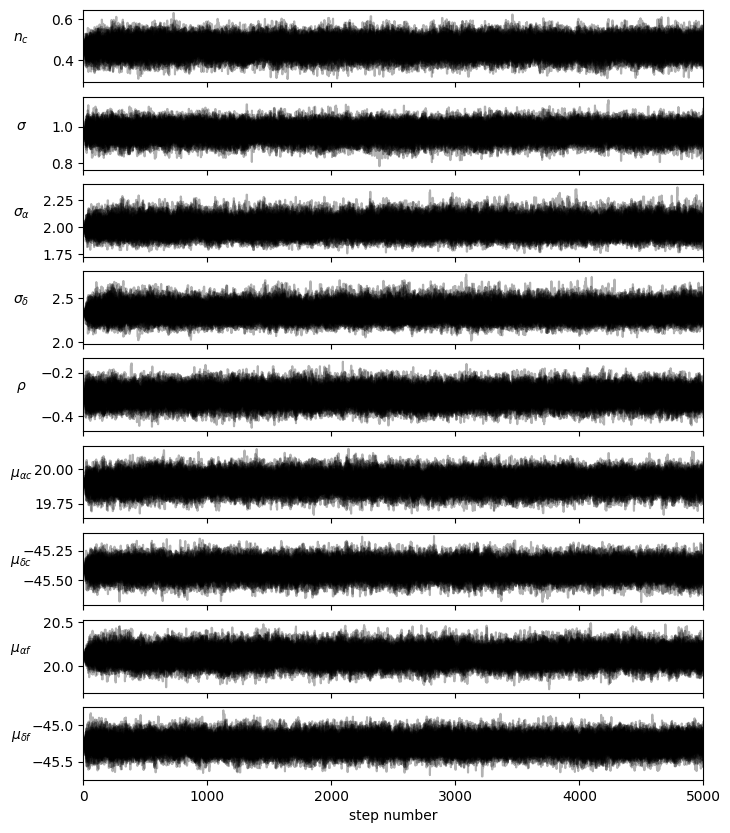

In [18]:
fig, axes = plt.subplots(n_dim, figsize=(8, 10), sharex=True)
samples = sampler.get_chain()
labels = ["$n_c$", "$\sigma$", "$\sigma_{\\alpha}$", "$\sigma_{\delta}$", "$\\rho$",
          "$\mu_{\\alpha c}$", "$\mu_{\delta c}$", "$\mu_{\\alpha f}$", "$\mu_{\delta f}$"]
for i in range(n_dim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i], rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")

Minimize: [  0.45725415   0.9604988    1.98815784   2.32863473  -0.30832104
  19.90156332 -45.40793731  20.10917793 -45.26290336]
MCMC:     [  0.46736811   0.96903772   1.99070471   2.34925087  -0.31328863
  19.89596061 -45.40586208  20.11378327 -45.24048335]
(32600, 9)


<Figure size 800x800 with 0 Axes>

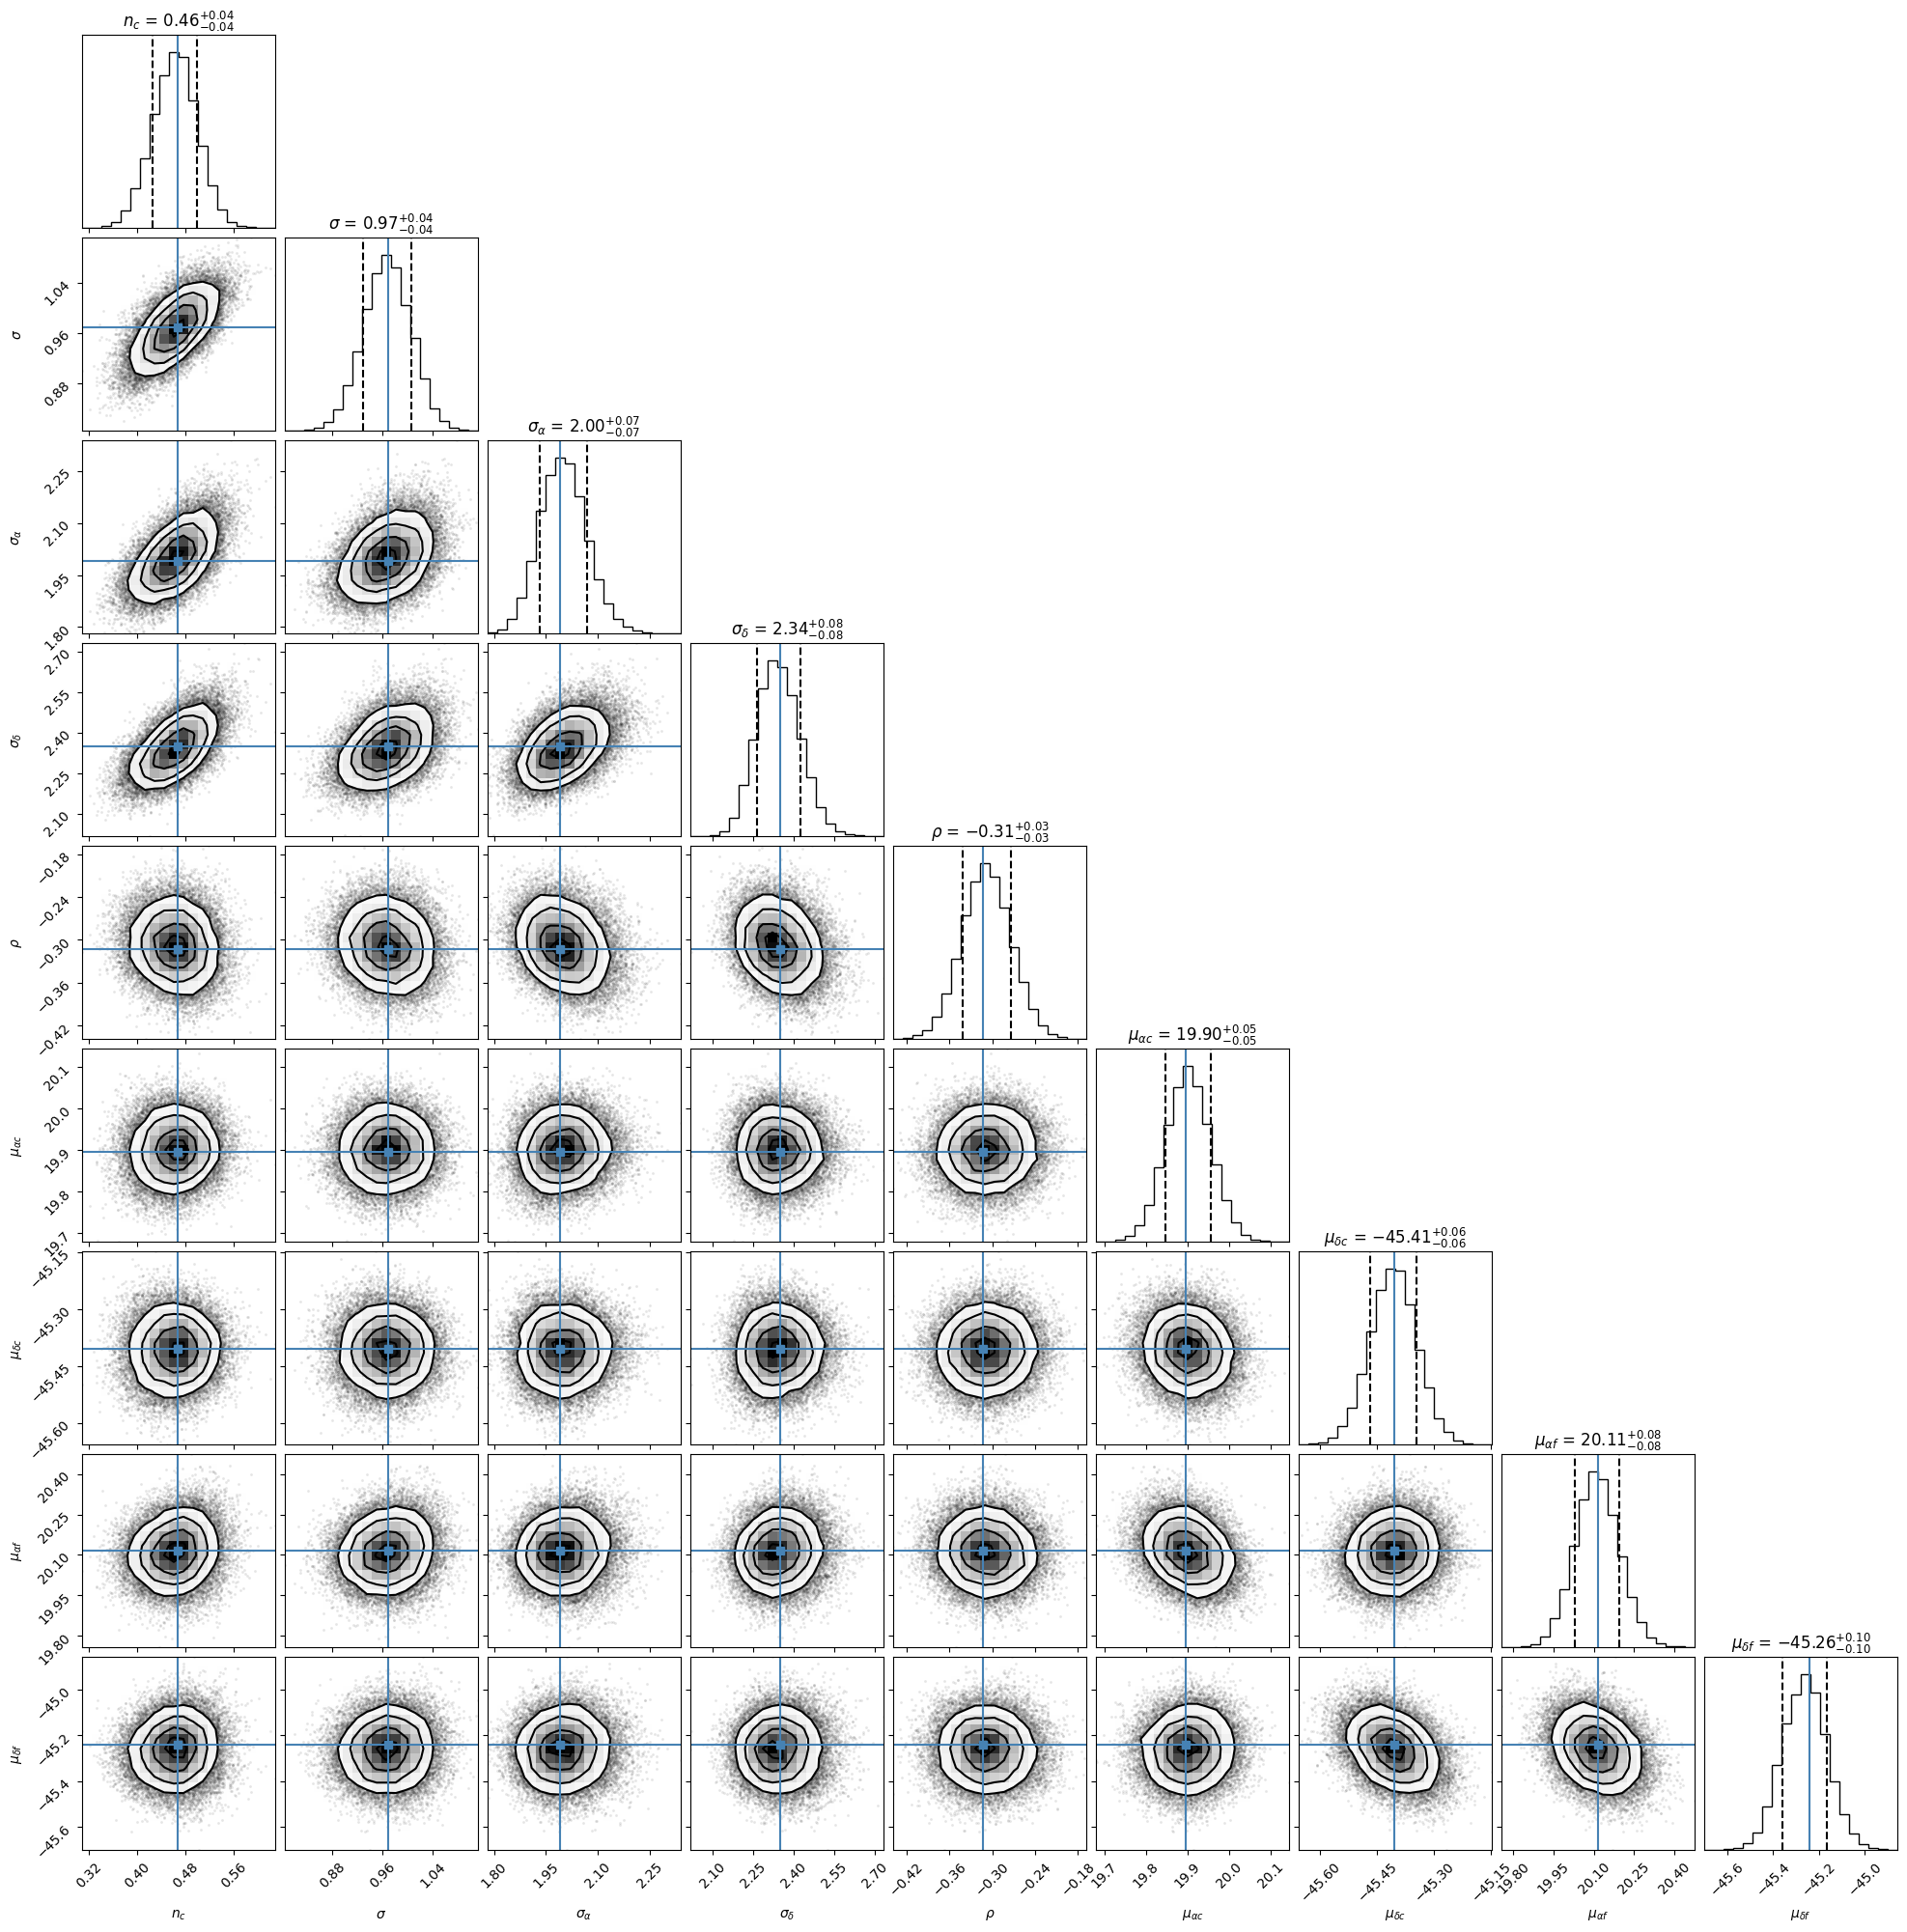

In [23]:
params_mcmc = np.percentile(pos ,50, axis=0)
#maxprob_indice = np.argmax(prob)
#params_mcmc = pos[maxprob_indice]

print('Minimize:',results.x)
print('MCMC:    ',params_mcmc)

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)
truths = params_mcmc

plt.figure(figsize=(8,8)) #quantiles=[0.16, 0.5, 0.84]
fig = corner.corner(flat_samples, labels=labels, truths=truths, quantiles=[0.16, 0.84], show_titles=True,
                      title_kwargs={"fontsize": 12})#rasterized=True
plt.savefig('./corner_pleiades.jpg',bbox_inches = "tight")

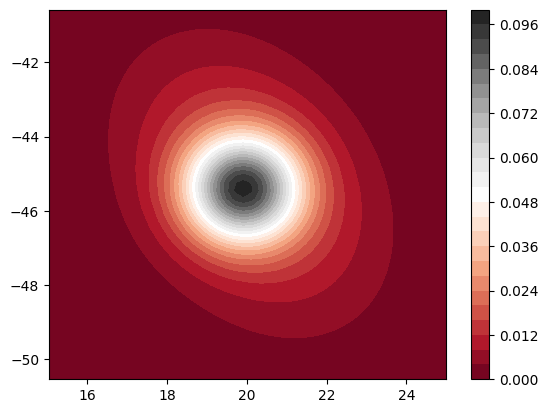

In [9]:
x = np.linspace(min(df.pmra), max(df.pmra), 50)
y = np.linspace(min(df.pmdec), max(df.pmdec), 50)

def func(x, y, params):
    nc, s, sx, sy, rho, mu_xc, mu_yc, mu_xf, mu_yf = params
    amp_circ = nc / (2 * np.pi * s**2)
    amp_elip = (1-nc) / (2 * np.pi * sx * sy * np.sqrt(1 - rho**2))
    Exp_circ = -0.5 * (((x - mu_xc)/s)**2 + ((y - mu_yc)/s)**2)
    Exp_elip = -1/(2*(1-rho**2))*(((x - mu_xf)/sx)**2+((y - mu_yf)/sy)**2-2*rho*((x - mu_xf)/sx)*((y - mu_yf)/sy))
    z = amp_circ * np.exp(Exp_circ) + amp_elip * np.exp(Exp_elip)
    return z


X, Y = np.meshgrid(x, y)
Z = func(X, Y, results.x)

plt.contourf(X, Y, Z, 30, cmap='RdGy')
plt.colorbar()

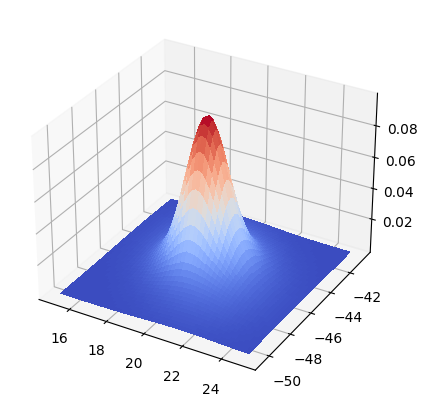

In [10]:
from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=(5, 5))
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,linewidth=0, antialiased=False)

0.8029344932500205


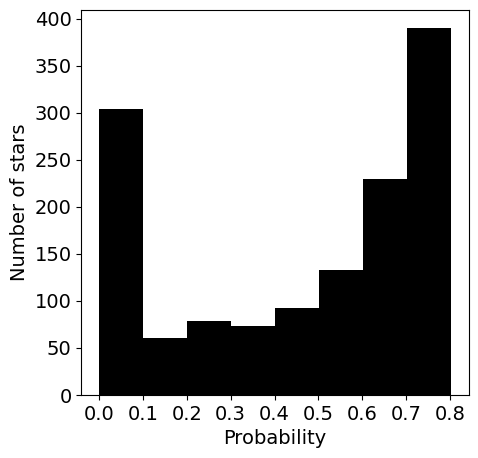

In [11]:
#nf, s, sx, sy, rho, mu_xc, mu_yc, mu_xf, mu_yf = truths
nc, s, sx, sy, rho, mu_xc, mu_yc, mu_xf, mu_yf = results.x

def probabilidad_circ(xy, nc, s, mu_xc, mu_yc):
    x, y = xy
    amp_circ =  1 / (2 * np.pi * s**2)
    Exp_circ = - 1/2 * (((x - mu_xc)/s)**2 + ((y - mu_yc)/s)**2)
    return nc * amp_circ * np.exp(Exp_circ)

def probabilidad_elip(xy, nc, sx, sy, rho, mu_xf, mu_yf):
    x, y = xy
    amp_elip = 1 / (2 * np.pi * sx * sy * np.sqrt(1 - rho**2))
    Exp_elip = - 1/(2*(1-rho**2))*(((x - mu_xf)/sx)**2+((y - mu_yf)/sy)**2-2*rho*((x - mu_xf)/sx)*((y - mu_yf)/sy))
    return (1-nc) * amp_elip * np.exp(Exp_elip)

xy = np.vstack((df.pmra, df.pmdec))
param_circ_prob = (nc, s, mu_xc, mu_yc)
param_elip_prob = (nc, sx, sy, rho, mu_xf, mu_yf)
p_circ = probabilidad_circ(xy, *param_circ_prob)
p_elip = probabilidad_elip(xy, *param_elip_prob)
prob = p_circ / (p_circ + p_elip)
#print('Min: {:.10f} Max: {:.10f}'.format(min(prob), max(prob)))
prob_limit = 0.5
members = (prob >= prob_limit)
no_members = (prob < prob_limit)
print(max(prob))
plt.figure(figsize=(5,5))
#plt.hist(prob, bins=5,range=[min(prob), 0.5], label='Field stars',color='gray')
#plt.hist(prob[(prob > 0.5)], bins=5,color='cyan',label='Cluster stars')
plt.hist(prob, bins=8,range=[min(prob), max(prob)],color='black')#histtype='step'
plt.xlabel('Probability',fontsize=14)
plt.ylabel('Number of stars',fontsize=14)
plt.xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
#plt.axvline(x = 0.5, color = 'black', label = 'Cut off', linestyle = '--')
#plt.legend()
#plt.savefig('./results/pleiades_probabilities.jpg',bbox_inches = "tight")
plt.show()

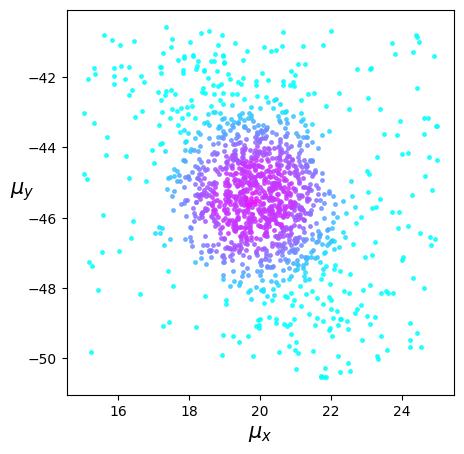

In [12]:
#colors=['black','dimgray','darkgrey','gainsboro','wheat','rosybrown','lightcoral','indianred','salmon','red']
#loop = np.arange(0.0, 1.0, 0.1)
loop = np.arange(0.0, 1.0, 0.1)
colors = [plt.cm.cool(each) for each in np.linspace(0, 1, len(loop))]

plt.figure(figsize=(5,5))
for i,c in zip(loop, colors):
  cond = (prob >= i) & (prob < i + 0.1)
  pmra_, pmdec_ = df.pmra[(cond)], df.pmdec[(cond)]
  plt.plot(pmra_, pmdec_,marker='.',c=c,linestyle='None',markersize=5,alpha=0.8)
plt.xlabel("$\mu_{x}$", fontsize = 15)
plt.ylabel("$\mu_{y}$", fontsize = 15,rotation=0)
#plt.savefig('./VPDClasses.jpg')
plt.show()

In [13]:
df['probability'] = prob
m45_members = df[members]
#m45_members.to_csv('./pleiades_PMmodel.csv')
print(len(m45_members))
m45_members

754


,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,...,g,g_error,rp,rp_error,bp,bp_error,rv,rv_error,ruwe,probability
175,63449521800719488,55.773982,0.079372,21.030220,0.058686,0.007661,0.000102,19.368667,0.119068,-46.283156,...,17.138874,2.743944,15.843201,15.539463,19.031832,7.887697,0.000000,0.000000,0.984827,0.742882
371,63507860340462208,56.593062,0.223397,21.088765,0.156204,0.007590,0.000266,20.472016,0.275824,-46.552291,...,18.534664,1.763879,17.123377,11.337544,20.782875,6.528066,0.000000,0.000000,0.999825,0.659040
467,63527827643105408,56.532550,0.173796,21.345159,0.133183,0.007235,0.000185,19.009062,0.237064,-45.063595,...,18.706327,1.449828,17.319443,10.996151,20.768375,5.878046,0.000000,0.000000,0.955010,0.741323
469,65588484235454592,58.268967,0.013425,22.801153,0.008666,0.007293,0.000015,19.036700,0.017368,-45.560948,...,13.100869,73.891630,12.250756,178.715670,13.850247,130.469680,6.250218,0.944959,1.044438,0.762607
609,65603946117575936,58.256849,0.057003,22.979900,0.040717,0.007421,0.000066,18.679104,0.075586,-45.228349,...,16.564484,4.894555,15.292191,15.388158,18.348476,8.440956,0.000000,0.000000,1.047237,0.699874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72424,119443869432136192,53.082068,0.108842,28.061936,0.094076,0.007691,0.000122,21.112930,0.132506,-45.442445,...,17.467590,2.911695,16.157310,12.877398,19.440117,8.510055,0.000000,0.000000,0.949544,0.674073
73023,119520079331712896,54.183900,0.013498,28.550263,0.010055,0.007236,0.000015,19.719203,0.016437,-45.515390,...,12.181860,119.751600,11.463689,245.024960,12.759123,172.960170,25.088032,0.891130,1.056813,0.802575
74327,119707889661936768,52.566314,0.031083,28.581672,0.022374,0.007394,0.000036,20.277727,0.036524,-47.068419,...,15.080872,18.677797,13.937094,39.469643,16.435133,16.455122,-4.663462,11.072157,1.093844,0.533569
74685,119776604841920896,53.630066,0.091859,28.841984,0.073737,0.007232,0.000101,20.992627,0.114394,-44.524271,...,17.389180,3.409288,16.075298,18.830961,19.325594,12.794014,0.000000,0.000000,1.014917,0.630900


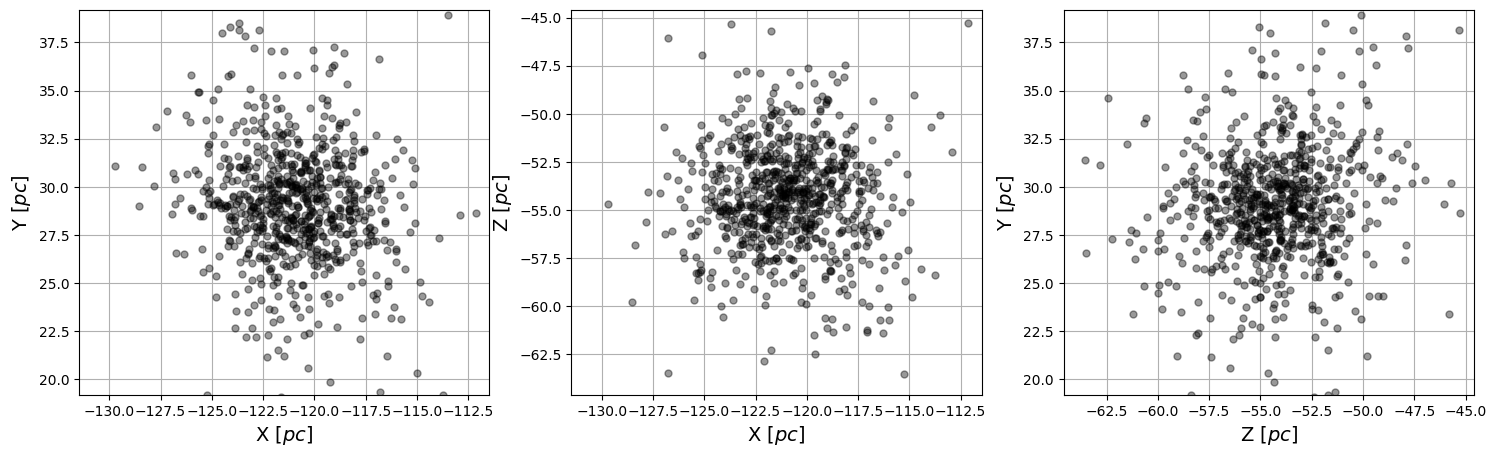

In [14]:
import astropy.units as u
import astropy.coordinates as apycoords

df_test = m45_members

ra_ = df_test['ra'] *u.deg
dec_ = df_test['dec'] *u.deg
distance_ = np.array(1/df_test['parallax']) *u.pc

c = apycoords.SkyCoord(ra=ra_,dec=dec_,distance=distance_,frame='icrs')
#print("(X,Y,Z) in (kpc,kpc,kpc)")
#print("\t",c.galactic.cartesian)
x = c.galactic.cartesian.x
y = c.galactic.cartesian.y
z = c.galactic.cartesian.z

xp = np.mean(x.to_value())
yp = np.mean(y.to_value())
zp = np.mean(z.to_value())
value = 10

%matplotlib inline
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.plot(x, y,color='k',marker='o',linestyle='None',markersize=5,alpha=0.4)
plt.xlim(xp - value,xp + value)
plt.ylim(yp - value,yp + value)
plt.xlabel("X $[pc]$", fontsize = 14)
plt.ylabel("Y $[pc]$", fontsize = 14)#,rotation=0)
plt.grid()

plt.subplot(1,3,2)
plt.plot(x, z,color='k',marker='o',linestyle='None',markersize=5,alpha=0.4)
plt.xlim(xp - value,xp + value)
plt.ylim(zp - value,zp + value)
plt.xlabel("X $[pc]$", fontsize = 14)
plt.ylabel("Z $[pc]$", fontsize = 14)#,rotation=0)
plt.grid()

plt.subplot(1,3,3)
plt.plot(z, y,color='k',marker='o',linestyle='None',markersize=5,alpha=0.4)
plt.xlim(zp - value,zp + value)
plt.ylim(yp - value,yp + value)
plt.xlabel("Z $[pc]$", fontsize = 14)
plt.ylabel("Y $[pc]$", fontsize = 14)#,rotation=0)
plt.grid()
#plt.savefig('./results/distribucion_espacial_test.jpg')
plt.show()